## 이미지 증식 -> 낮밤으로 구분하기 위하여 명도 조절

In [1]:
import os
import glob
import numpy as np

path = './doro/'
full_names = os.listdir(path)
labels = sorted([each.split('.')[0] for each in full_names])

In [4]:
from tqdm.notebook import tqdm #진행도 확인
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import cv2

os.mkdir('./doro_image') #증식 사진 저장할 폴더 만들기

range_ = tqdm(labels)
for dir_num in range_:
    # 이미지 로드
    img = load_img("./doro/{}.png".format(dir_num))
    # 배열로 변환
    data = img_to_array(img)
    # 차원추가 sample 1
    samples = expand_dims(data, 0)
    # 이미지 데이터 증식
    datagen = ImageDataGenerator(
        brightness_range=[0.4, 1.5], #밝기 조절
        zoom_range=[0.3, 0.5]) #줌 범위 30~50
#         rotation_range=20, #회전각도 20 이내
#         height_shift_range=0.2,
#         width_shift_range=0.2) #이동 범위 20
    # prepare iterator
    it = datagen.flow(samples, batch_size=1)
    os.mkdir('./doro_image/{}'.format(dir_num))

    for i in range(10): #각 이미지당 10장씩 증식
        batch = it.next()
        image = batch[0].astype("uint8")
        # rgb 변환
        b, g, r = cv2.split(image)
        img_astro3_rgb = cv2.merge([r, g, b])
        cv2.imwrite("./doro_image/{}/{}_{}.png".format(dir_num,
                                                          dir_num, i), img_astro3_rgb)

  0%|          | 0/244 [00:00<?, ?it/s]

In [5]:
from PIL import Image
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "./doro_image/"
categories = labels
nb_classes = len(labels)

image_w = 64
image_h = 64

X = []
y = []

for idx, cat in enumerate(categories):

    #   one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + str(cat)
    files = glob.glob(image_dir+"/*.png")
    #print(cat, " 파일 길이 : ", len(files))
    # 이미지 파일을 64 x 64 로 줄이고, 벡터화 시켜 X에 저장, one-hot-encoding된 라벨도 저장
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

X = np.array(X)
y = np.array(y)

carroad_1  파일 길이 :  10
carroad_102  파일 길이 :  10
carroad_103  파일 길이 :  10
carroad_1052  파일 길이 :  10
carroad_106  파일 길이 :  10
carroad_107  파일 길이 :  10
carroad_1073  파일 길이 :  10
carroad_1076  파일 길이 :  10
carroad_1077  파일 길이 :  10
carroad_1088  파일 길이 :  10
carroad_1089  파일 길이 :  10
carroad_110  파일 길이 :  10
carroad_1108  파일 길이 :  10
carroad_1109  파일 길이 :  10
carroad_1112  파일 길이 :  10
carroad_1113  파일 길이 :  10
carroad_1116  파일 길이 :  10
carroad_1117  파일 길이 :  10
carroad_1128  파일 길이 :  10
carroad_1201  파일 길이 :  10
carroad_125  파일 길이 :  10
carroad_130  파일 길이 :  10
carroad_133  파일 길이 :  10
carroad_141  파일 길이 :  10
carroad_153  파일 길이 :  10
carroad_2  파일 길이 :  10
carroad_3  파일 길이 :  10
carroad_33  파일 길이 :  10
carroad_34  파일 길이 :  10
carroad_37  파일 길이 :  10
carroad_38  파일 길이 :  10
carroad_4  파일 길이 :  10
carroad_41  파일 길이 :  10
carroad_42  파일 길이 :  10
carroad_45  파일 길이 :  10
carroad_46  파일 길이 :  10
carroad_49  파일 길이 :  10
carroad_5  파일 길이 :  10
carroad_50  파일 길이 :  10
carroad_53  파일 길이 :  10
carroad

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)

In [7]:
X_train.shape

(1830, 64, 64, 3)

In [8]:
y_train_test = y_train.reshape(-1,1)
y_train_test.shape

(446520, 1)

In [9]:
y_train.shape

(1830, 244)

In [10]:
## 행렬을 피클로 저장
import pickle 
pickle.dump(xy, open("./model/multi_image_data.npy", 'wb'), protocol=4)

In [11]:
import numpy as np

In [12]:
#넘파이 파일 불러오기
X_train, X_test, y_train, y_test = np.load('./model/multi_image_data.npy',allow_pickle=True)

In [13]:
X_train.shape #(10327, 64, 64, 3)
y_train.shape #(10327, 1377)

(1830, 244)

In [14]:
## 정규화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [18]:
## 모델링
import os
import glob
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt
# import keras.backend.tensorflow_backend as K
# from keras import backend as K #-> gpu 사용시 import / gpu를 구분하여 사용하기 어려우니 비권장

nb_classes = len(labels)

model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same",
                 input_shape=X_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

# 학습
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model_dir = './model'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_path = model_dir + '/multi_img_classification.model'
checkpoint = ModelCheckpoint(
    filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)


# dropout 제거
# batch_size 수정
# epochs 증대

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 128)       

In [20]:
history = model.fit(X_train, y_train, batch_size=10, epochs=50, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/50
147/147 [==============================] - 14s 83ms/step - loss: 5.5098 - accuracy: 0.0061 - val_loss: 5.5372 - val_accuracy: 0.0027
Epoch 2/50
147/147 [==============================] - 12s 81ms/step - loss: 5.2968 - accuracy: 0.0348 - val_loss: 4.6595 - val_accuracy: 0.1366
Epoch 3/50
147/147 [==============================] - 12s 81ms/step - loss: 2.6588 - accuracy: 0.4392 - val_loss: 2.0649 - val_accuracy: 0.5437
Epoch 4/50
147/147 [==============================] - 12s 82ms/step - loss: 0.9562 - accuracy: 0.7534 - val_loss: 1.1794 - val_accuracy: 0.7322
Epoch 5/50
147/147 [==============================] - 12s 82ms/step - loss: 0.5774 - accuracy: 0.8477 - val_loss: 0.9509 - val_accuracy: 0.7951
Epoch 6/50
147/147 [==============================] - 12s 83ms/step - loss: 0.4007 - accuracy: 0.8941 - val_loss: 0.7128 - val_accuracy: 0.8415
Epoch 7/50
147/147 [==============================] - 12s 82ms/step - loss: 0.2918 - accuracy: 0.9133 - val_loss: 1.0014 - val_accuracy:

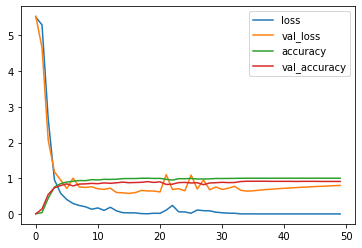

In [21]:
plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
for each in plot_target:
    plt.plot(history.history[each], label=each)
    
plt.legend()
plt.show()

In [22]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 1s 54ms/step - loss: 0.5610 - accuracy: 0.9213


[0.5610292553901672, 0.9213114976882935]